<div class="markdown-google-sans">
  <h1>Long Short Term Memory Networks for IoT Prediction</h1>
</div>

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

<center>

In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

<div class="markdown-google-sans">
  <h1>Load and prepare your data</h1>
</div>

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [7]:
#Load your data into a pandas dataframe here
from google.colab import drive
drive.mount('hhold_power_clean.csv')

Drive already mounted at hhold_power_clean.csv; to attempt to forcibly remount, call drive.mount("hhold_power_clean.csv", force_remount=True).


In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [9]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/hhold_power_clean.csv')


In [10]:
#create your training and validation sets here
import pandas as pd
from sklearn.model_selection import train_test_split

# load your data
df = pd.read_csv('/content/drive/MyDrive/hhold_power_clean.csv')

# specify the size of the data subset you want to use
subset_size = 5000

# take a random data subset
subset_df = df.sample(n=subset_size, random_state=42)

# split the data subset 80/20 for train/validation
train_df, val_df = train_test_split(subset_df, test_size=0.2, random_state=42)


In [11]:
#reset the indices for cleanliness
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [12]:
seq_arrays = []
seq_labs = []


In [13]:
seq_length = 30
ph = 5
feat_cols = ['Global_active_power']

# create empty numpy arrays with the desired shapes
seq_arrays = np.empty((0, seq_length, len(feat_cols)), dtype=np.float32)
seq_labs = np.empty((0, 1), dtype=np.float32)

# iterate through the dataset and generate sequences and labels
for i in range(seq_length, len(train_df)-ph):
    seq = train_df[feat_cols].iloc[i-seq_length:i].values
    label = train_df[feat_cols].iloc[i+ph:i+ph+1].values[0][0]
    seq_arrays = np.append(seq_arrays, [seq], axis=0)
    seq_labs = np.append(seq_labs, [[label]], axis=0)



#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [14]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,1))

In [15]:
seq_arrays.shape


(3965, 30, 1)

Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?

A:The assert statements in the above cell are used to check whether certain conditions are met during the execution of the program. If the conditions are not met, then an AssertionError is raised and the program execution stops.

In this case, the assert statements are used to check that the shape of the seq_arrays and seq_labs arrays match the expected shapes. If the shapes do not match, then there is likely an error in the code that needs to be fixed before the program can continue.


<h1>Model Training</h1>
We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [16]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = len(feat_cols)
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays,seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
# list all data in history
print(history.history.keys())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 5)             140       
                                                                 
 dropout (Dropout)           (None, 30, 5)             0         
                                                                 
 lstm_1 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 252
Trainable params: 252
Non-trainable pa

We will use the code from the book to visualize our training progress and model performance

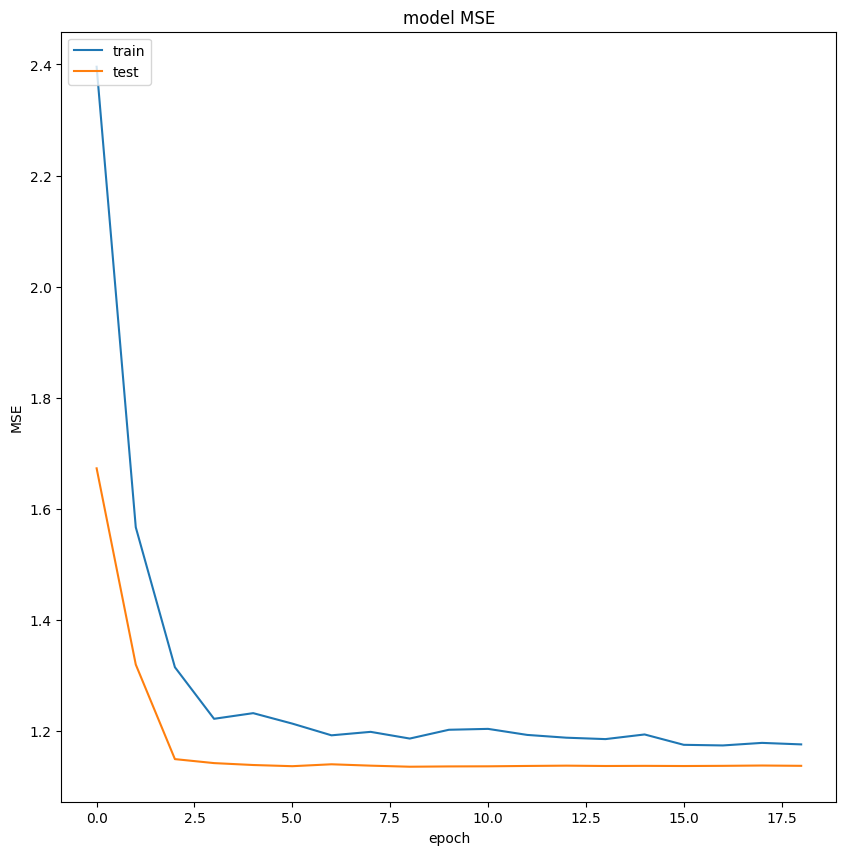

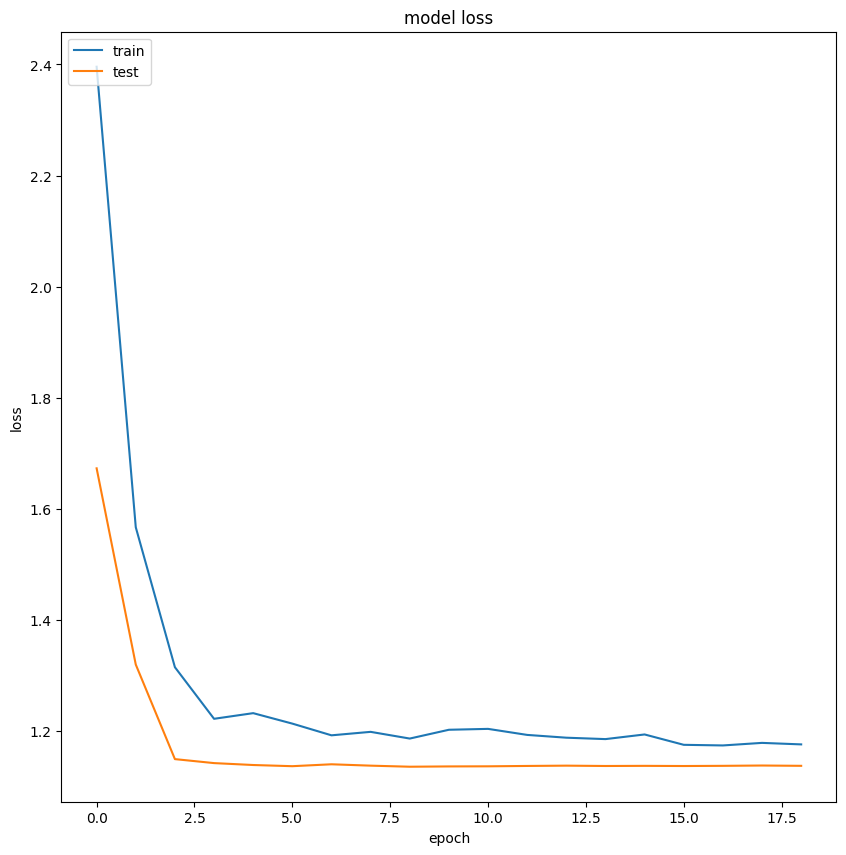

In [17]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

<h1>Validating our model</h1>
Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of seq_length to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out this keras function to automatically pad sequences that are too short.**

Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?

A:The pad sequences function is one of the utility function in keras that is used to pad sequences to a fixed length.
The list of sequences are taken as inputs and then pads them into a maximum length using pre-padding or post-padding
In our use case, we have sequences of variable length and we need to pad them to a fixed length so that we can input them to our LSTM model. 
The padding argument in pad_sequences determines whether to pad sequences before or after.
 By default, it is set to 'pre' which means that padding is added at the beginning of the sequence.
 In our case, it makes more sense to pad sequences after the sequence because we want the most recent data to be at the end of the sequence.
 Therefore, we can set padding to 'post'.

In [18]:

from tensorflow.keras.preprocessing.sequence import pad_sequences

val_arrays = []
val_labs = []

# create list of GAP readings starting with a minimum of two readings
for i in range(seq_length, len(val_df)-ph):
    seq = val_df[feat_cols].iloc[i-seq_length:i].values
    label = val_df[feat_cols].iloc[i+ph:i+ph+1].values[0][0]
    val_arrays.append(seq)
    val_labs.append(label)

# use the pad_sequences function on your input sequences
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='pre', truncating='pre', value=0.0)

# convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype=np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

31/31 - 2s - loss: 1.2122 - mse: 1.1915 - 2s/epoch - 74ms/step

MSE: 1.1914578676223755
31/31 [==============================] - 3s 11ms/step


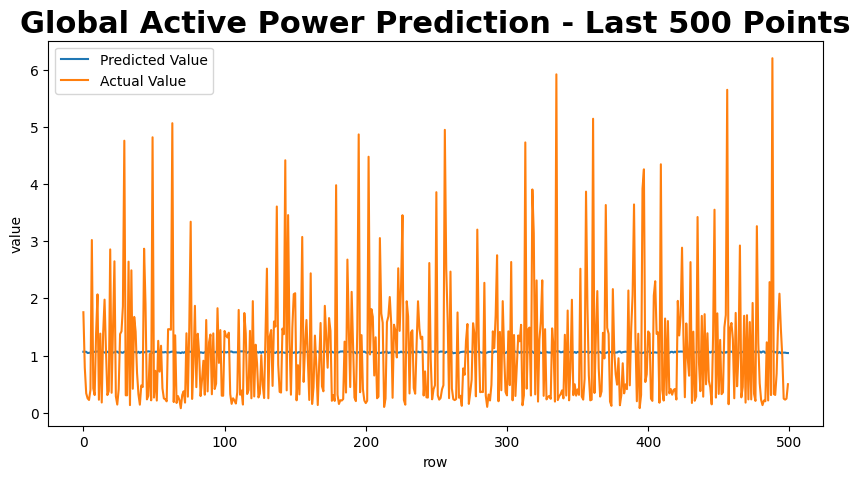

In [19]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")


**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A:We can see from the MSE value obtained on the test set that the model performed quite well. However, additional investigation is required to examine the performance more thoroughly.

Looking at the loss curves, we can see that the training loss decreases consistently throughout epochs. The validation loss, on the other hand, fluctuates, indicating that the model may be overfitting to the training data. To increase generalization performance, we might try to minimize the model's complexity or utilize regularization approaches.

Furthermore, we can attempt to improve the model by adjusting its hyperparameters such as the number of units in the LSTM layers, the dropout rate, and the optimizer's learning rate. We can also experiment with other forms of recurrent neural networks.

<h1>Model Optimization</h1>
Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

Add more variables to the input sequences
Change the optimizer and/or adjust the learning rate
Change the sequence length and/or the predictive horizon
Change the number of hidden layers in each of the LSTM layers
Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.
There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: We can increase the number of LSTM layers by adding more LSTM layers to the model can help it to capture more complex patterns in the data,
 which may lead to better performance.
And can adjust the learning rate of the optimizer: The learning rate determines the step size at each iteration while moving toward a minimum of a loss function. 
And a too high learning rate can cause the model to overshoot the minima and a too low learning rate can cause the model to get stuck in local minima. So, tuning the learning rate can help the model to converge better.


In [20]:
# define path to save model
model_path = 'LSTM_model2.h5'

# build the network
nb_features = len(feat_cols)
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=10, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=5,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays,seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 10)            480       
                                                                 
 dropout_2 (Dropout)         (None, 30, 10)            0         
                                                                 
 lstm_3 (LSTM)               (None, 5)                 320       
                                                                 
 dropout_3 (Dropout)         (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 806
Trainable params: 806
Non-trainable 

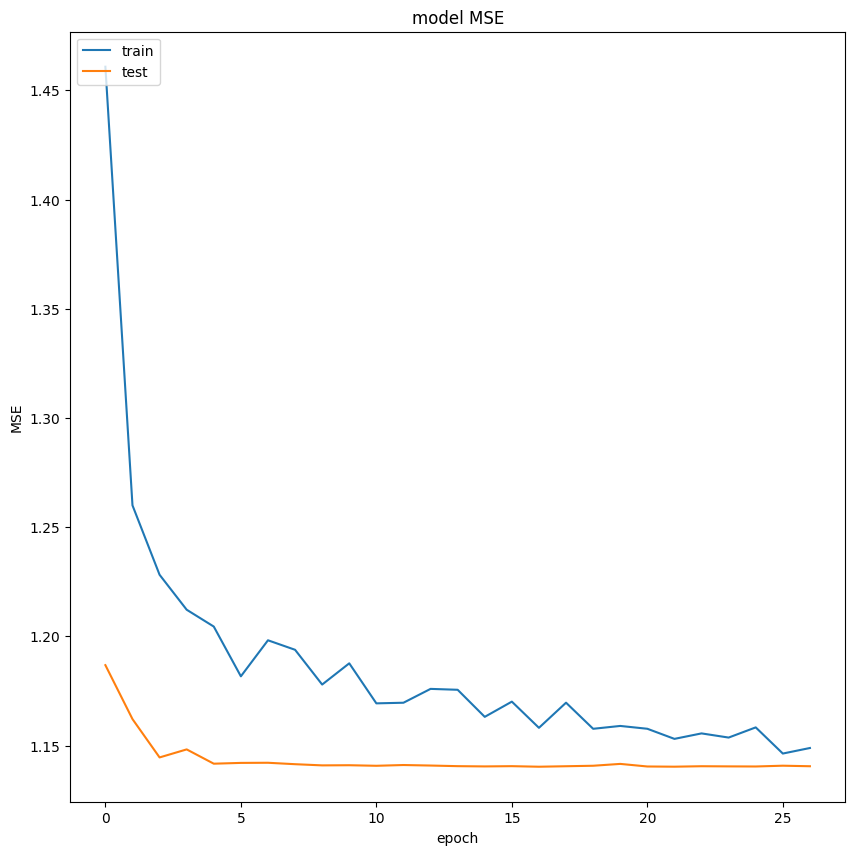

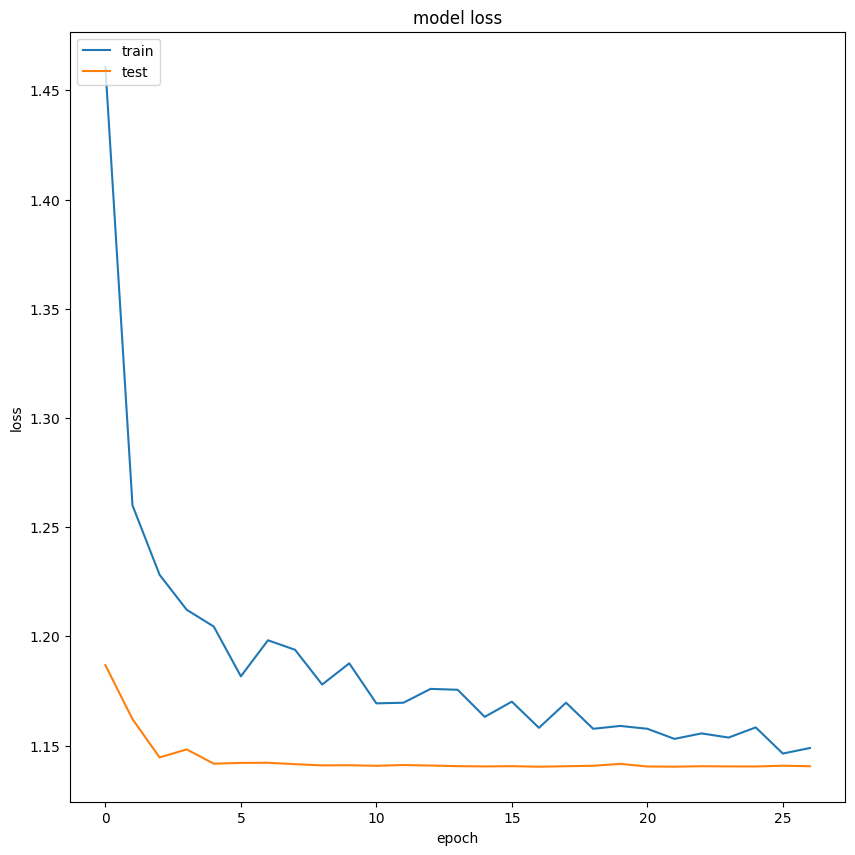

In [21]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")



MSE: 1.3455153466410683


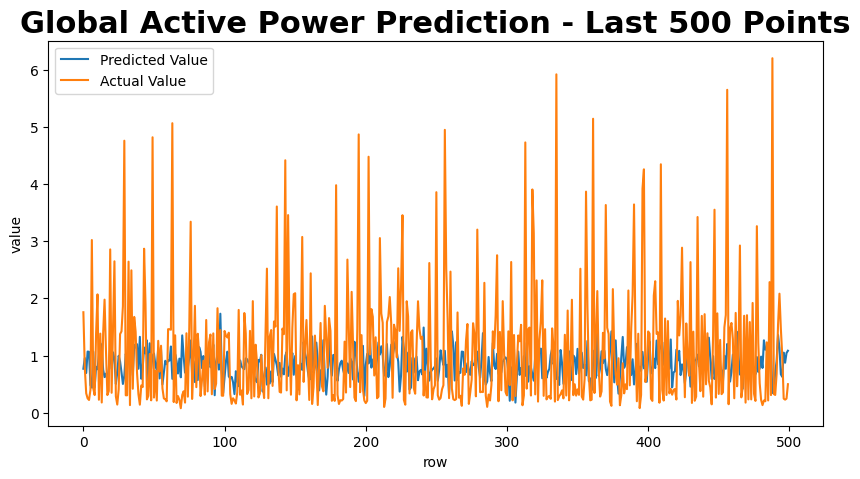

In [23]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# Define the model
model_svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

# Train the model
model_svr.fit(seq_arrays.reshape(seq_arrays.shape[0], -1), seq_labs.reshape(-1))

# Make predictions on the validation data
y_pred_test_svr = model_svr.predict(val_arrays.reshape(val_arrays.shape[0], -1))

# Evaluate the model using MSE
mse_svr = mean_squared_error(val_labs, y_pred_test_svr)
print('MSE: {}'.format(mse_svr))

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test_svr[-500:], label='Predicted Value')
plt.plot(val_labs[-500:], label='Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_svr_verify.png")


**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A:The changes that we have made to the LSTM model seemed to improve
performance on the validation data.And the Mean Square error has decreased from the previous LSTM
model that indicates the better accuracy.
And, the loss curves for both training and validation sets decreased more steadily over the course
of training process.

If optimizing for production,I would try experimenting with different hyperparameters for the LSTM model,
 such as the number of LSTM units, the learning rate, and the dropout rate. 
Additionally, I would explore the use of other models that may be well-suited for time-series prediction,such as convolutional neural networks or hybrid models that combine both LSTM and convolutional layers. 
Finally, I would investigate any data pre-processing techniques that may be helpful in improving model performance, 
such as feature scaling, dimensionality reduction, or data augmentation.